<h1> The aim is to create a tokenizer which is bpe like tokenizer used in chat gpt </h1>


step1 : download the data

In [ ]:
with open("the-verdict.txt" , "r" ,encoding = "utf-8") as f:
  raw_text = f.read()

print(" Total number of characters "  , len(raw_text) )
print( raw_text[:90] )


 Total number of characters  20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so i


In [ ]:
with open("harryporter.txt" , 'r' , encoding = 'utf-8') as f :
  raw_text2 = f.read()
print(" len of the harry porter book is " , len(raw_text2) )
print(raw_text2[:100])

 len of the harry porter book is  439742
Harry Potter and the Sorcerer's Stone


CHAPTER ONE

THE BOY WHO LIVED

Mr. and Mrs. Dursley, of num


we will use the tiktoken for the bpe . it is fast as the innercode is written in rust.

question 1) lets say you are given the text = = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
) and asked to encode it .

In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.5 MB/s eta 0:00:00


In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
# get_encoding("model name ") will ge the tokenizer of corresponding model


In [ ]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)
test_encodings = tokenizer.encode(text , allowed_special={"<|endoftext|>"} )
decoded_text = tokenizer.decode(test_encodings )
print(test_encodings)
print(decoded_text)
# note always give the special tokens to allowed_special = {} so that they are considered as special tokens and will not be splited or breaked .

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


<div class="alert alert-block alert-warning">

We can make two noteworthy observations based on the token IDs and decoded text
above.

First, the <|endoftext|> token is assigned a relatively large token ID, namely,
50256.

In fact, the BPE tokenizer, which was used to train models such as GPT-2, GPT-3,
and the original model used in ChatGPT, has a total vocabulary size of 50,257, with
<|endoftext|> being assigned the largest token ID.
    


</div>

<div class="alert alert-block alert-warning">

Second, the BPE tokenizer above encodes and decodes unknown words, such as
"someunknownPlace" correctly.

The BPE tokenizer can handle any unknown word. How does
it achieve this without using <|unk|> tokens?
    


</div>

<div class="alert alert-block alert-warning">

The algorithm underlying BPE breaks down words that aren't in its predefined vocabulary
into smaller subword units or even individual characters.

The enables it to handle out-ofvocabulary words.

So, thanks to the BPE algorithm, if the tokenizer encounters an
unfamiliar word during tokenization, it can represent it as a sequence of subword tokens or
characters
    


</div>

** SEE THE BPE VIDEO TO UNDERSTAND THE BPE ALGO in vizuara CLEARLY
 **

QUESTION 2 : what is the behaviour of the tokenizer when un known words are seen demonstrate it with text = " helinaaba balinaba kuki kanma"

In [ ]:
text = " helinaaba balinaba kuki kanma "
test_encodings = tokenizer.encode(text)
for id in test_encodings:
  print(tokenizer.decode([id]) )
print()
decoded_text = tokenizer.decode(test_encodings )
print(decoded_text)

 hel
ina
aba
 bal
in
aba
 k
uki
 kan
ma
 

 helinaaba balinaba kuki kanma 


so see the text which is unknown is breaken down to small tokens and given ids . again so that it can be reformulated as the orginal text  

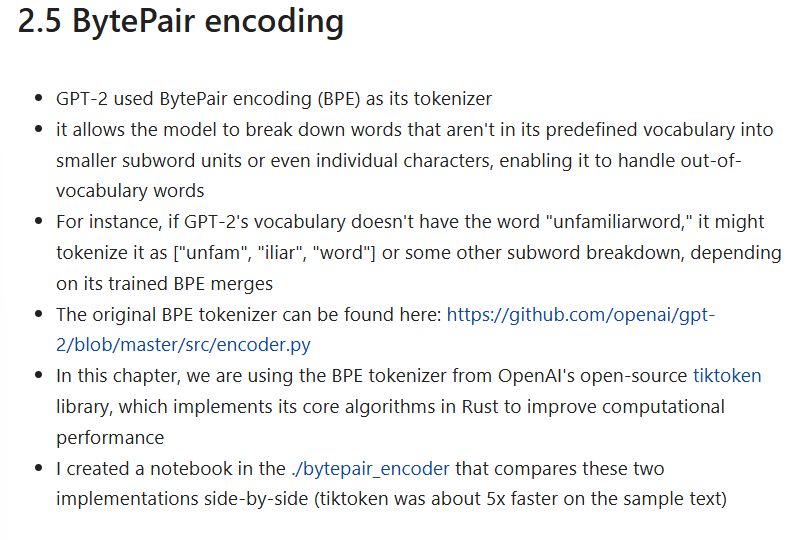

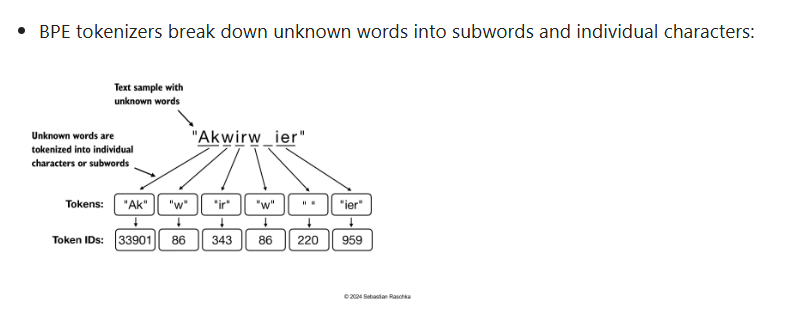

In [ ]:
print(raw_text[:50])
print(raw_text2[:100])
print(len(raw_text))
print(len(raw_text2))

I HAD always thought Jack Gisburn rather a cheap g
Harry Potter and the Sorcerer's Stone


CHAPTER ONE

THE BOY WHO LIVED

Mr. and Mrs. Dursley, of num
20479
439742


In [ ]:
enc_text = tokenizer.encode(raw_text)
enc_text2 = tokenizer.encode(raw_text2)

In [ ]:
print(len(enc_text))
print(len(enc_text2))


5145
116725


WE KNOW THAT LLMS BASIC TASK IS NEXT WORD PREDICTION .
consider the batch size / context size / seqlen = 4 .
question1 create a simple input expected and output pair expected .

In [ ]:
context_size = 4
x = enc_text[: context_size]
y = enc_text[1 : context_size +1]
print( f"{x} ---- input ")
print(f"     {y} ---- target ")
print("the training will happen like ")
for i in range(1 , context_size):
  print(f"{enc_text[:i]} ---->  {enc_text[i]}" )
for i in range(1 , context_size):
  print(f"{tokenizer.decode(enc_text[:i]) } ---->  {tokenizer.decode([enc_text[i]]) }" )

[40, 367, 2885, 1464] ---- input 
     [367, 2885, 1464, 1807] ---- target 
the training will happen like 
[40] ---->  367
[40, 367] ---->  2885
[40, 367, 2885] ---->  1464
I ---->   H
I H ---->  AD
I HAD ---->   always


QUESTION 2 create a data loader class with takes inputs as rawtext , batchsize , stride len and returns the dataloader

** Creating the dataloader always involves the 2 steps always
1) creating the dataset class
2) creating the data loader class to output the dataloader

not here we are using the pytorch torchutils.data  Dataset , DataLoader .
**

dataset class
here we have 3 things 1) __ init__ 2) __len__ 3) __getitem__

note that the get tem should always give the input and target paris as return

as the dataloader and datasets are interlinked .

ie dataloader laways expects the dataset to return the input , target pairs as the outputs .

In [ ]:
import torch
from torch.utils.data import Dataset , DataLoader

class GPTDatasetV1(Dataset):

  def __init__(self , txt , tokenizer , max_length , stride  ):
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.stride = stride
    self.input_ids = []
    self.target_ids = []

    token_ids = self.tokenizer.encode(txt)

    for i in range(0 , len(token_ids) - max_length , stride ):
      input_chunk = token_ids[i : i + max_length ]
      target_chunk = token_ids[ i+1 : i+1+ max_length ]
      self.input_ids.append(torch.tensor(input_chunk , dtype = torch.int32 ))
      self.target_ids.append(torch.tensor(target_chunk , dtype = torch.int32 ))


  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self , idx ):
    return self.input_ids[idx] , self.target_ids[idx]






WE HAVE THE DATALOADER


In [ ]:
def create_dataloader_v1(txt , batch_size = 4 , max_length = 256  , stride = 128 , shuffle = True , drop_last = True   , num_workers = 0  ):

  # initialize the tokenizer
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPTDatasetV1(txt , tokenizer , max_length , stride )
  dataloader = DataLoader(dataset , batch_size = batch_size , shuffle = True , drop_last = drop_last,
                          num_workers = num_workers )
  return dataloader



question :
** create a dataloader for the verdict data

with batch size = 8 , seqlenth = 4 , stride = 2 , shuffle = false **

In [ ]:
dataloader1 = create_dataloader_v1(raw_text , batch_size  = 8 , max_length = 4 , stride = 2 , shuffle = False )
data_iter = iter(dataloader1)
inputs , targets = next(data_iter)
print(f" inputs {inputs} ")
print(f" outputs {targets} ")
print(f" inputs :{tokenizer.decode(inputs[0].tolist())} ")
print(f" outputs : {tokenizer.decode(targets[0].tolist()) } ")


 inputs tensor([[  670,   319,   438, 15464],
        [ 7543,   284,   607,   599],
        [  314,  2936,   355,   611],
        [  257,  1611,   286, 24354],
        [ 3856, 44455,   351,   534],
        [   11,   314,  1422,   470],
        [ 1549,  1560,   502,   703],
        [ 2087,  9839,  1022,   514]], dtype=torch.int32) 
 outputs tensor([[  319,   438, 15464,    11],
        [  284,   607,   599,  6321],
        [ 2936,   355,   611,   339],
        [ 1611,   286, 24354, 20154],
        [44455,   351,   534, 24638],
        [  314,  1422,   470,   760],
        [ 1560,   502,   703,   340],
        [ 9839,  1022,   514,  2474]], dtype=torch.int32) 
 inputs  work on--forming 
 outputs  on--forming, 


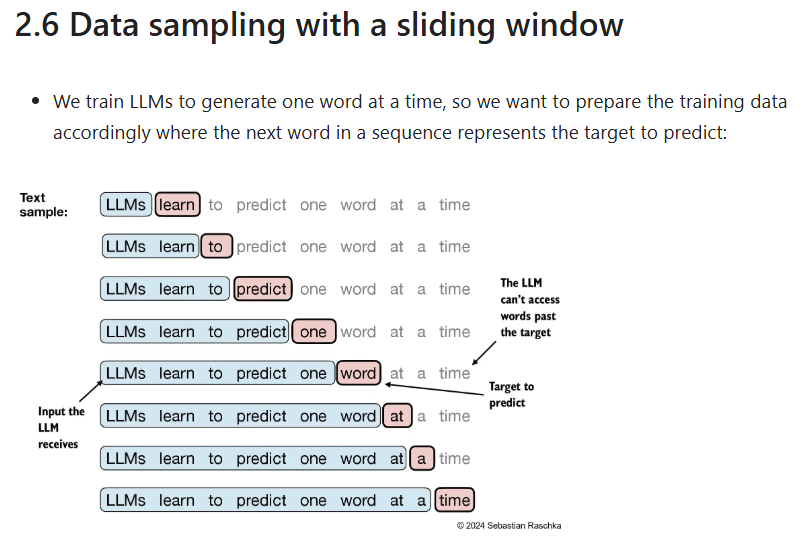

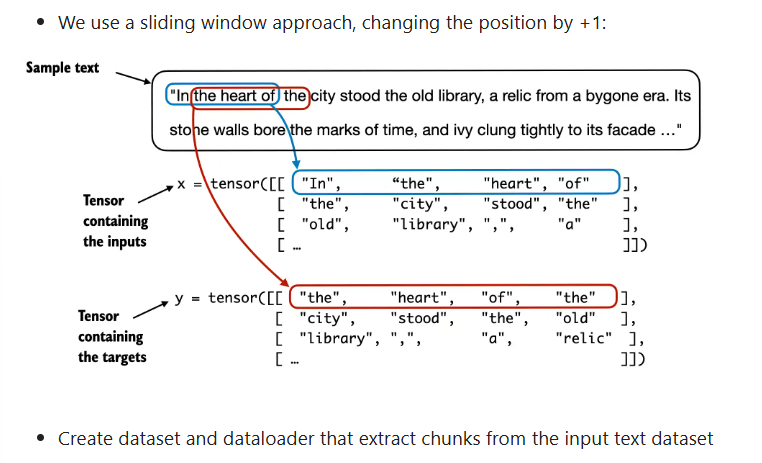

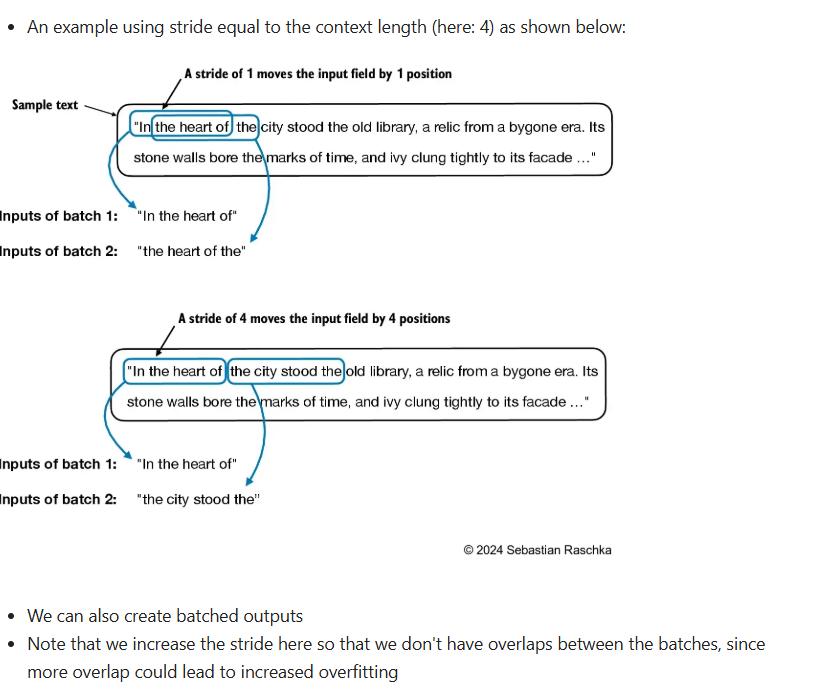

**Now lets build the embeddings **

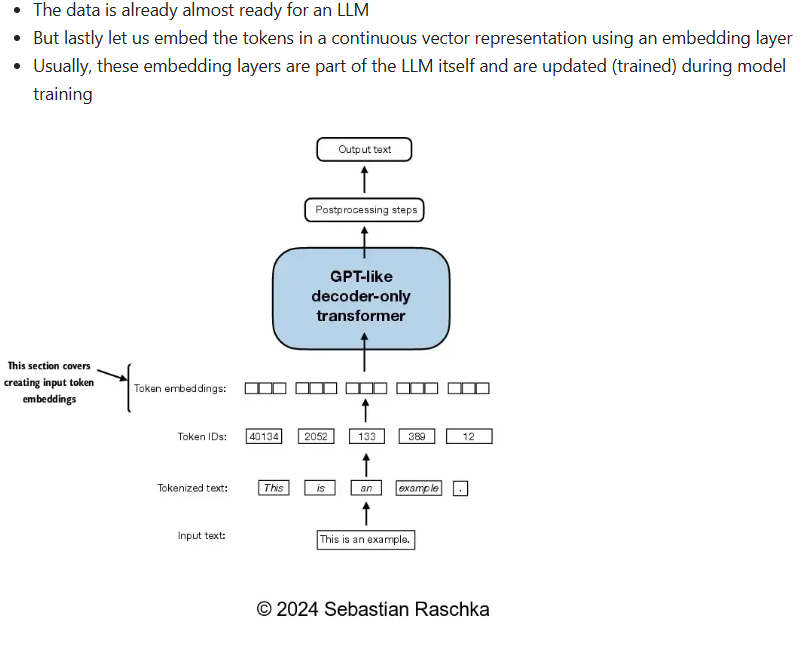

** normally we first assign  the tokeid to the embeddings using the nn.Embeddings which takes two inputs vocab size and embed size to form the embedings and then the each id has the embeddings . these are just some random emebed ings and see the notes for word to vec concept**

** question 1 : <br> hey you have vocab of size 6
and given sentnce is [2 , 4 , 0 , 1]  conver the sentence into words embeddings
<br>
1) print all the embeddings <br>
2) print the sentence in the form of word embeddings **

In [ ]:
from torch import nn
vocab_size = 6
embed_size = 3
embedding_layer = nn.Embedding(vocab_size , embed_size)
ids = torch.tensor([2 , 4 , 0 , 1])
embeds = embedding_layer(ids)
print(f" these are ids and corrrespondings embeds {embedding_layer.weight }")
print(f" these are embed os the text {embeds} ")



 these are ids and corrrespondings embeds Parameter containing:
tensor([[ 1.1151, -0.5696, -1.6095],
        [ 1.4472,  0.5631,  0.1647],
        [-0.3974,  1.5733, -0.3787],
        [ 1.2231,  0.2687, -1.0766],
        [ 0.1690, -1.1574, -0.1159],
        [ 1.3038,  0.2852,  0.8324]], requires_grad=True)
 these are embed os the text tensor([[-0.3974,  1.5733, -0.3787],
        [ 0.1690, -1.1574, -0.1159],
        [ 1.1151, -0.5696, -1.6095],
        [ 1.4472,  0.5631,  0.1647]], grad_fn=<EmbeddingBackward0>) 


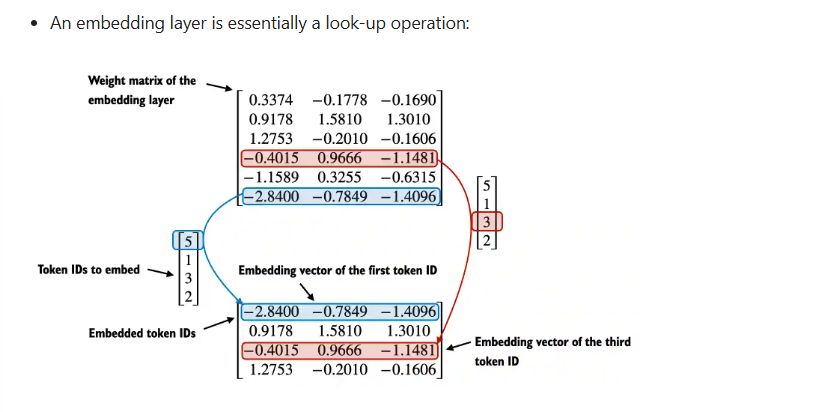

letsee the positional encodings


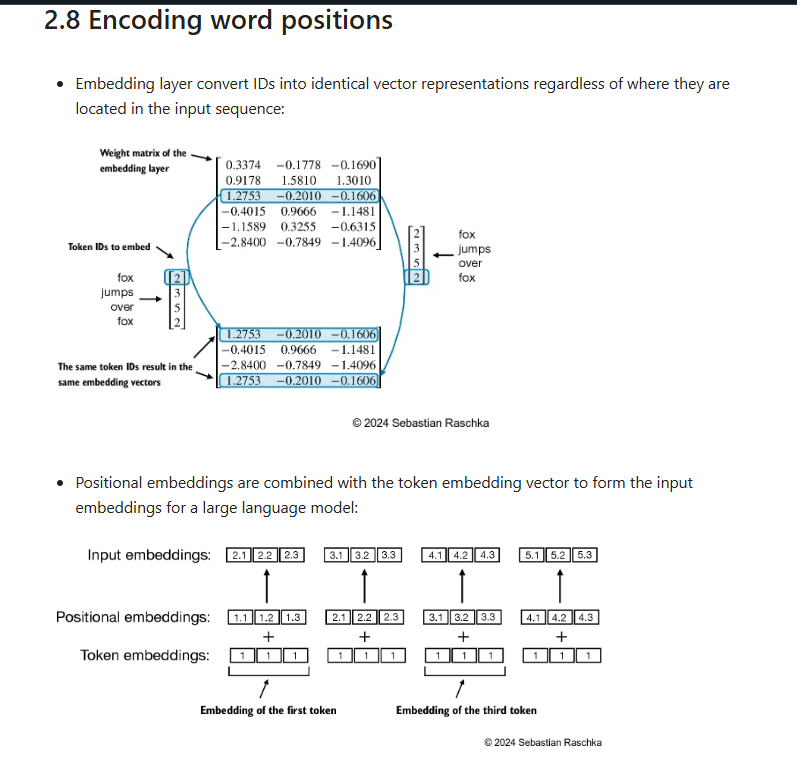

here we use the positional embeddings wich is used in the orginal gpt

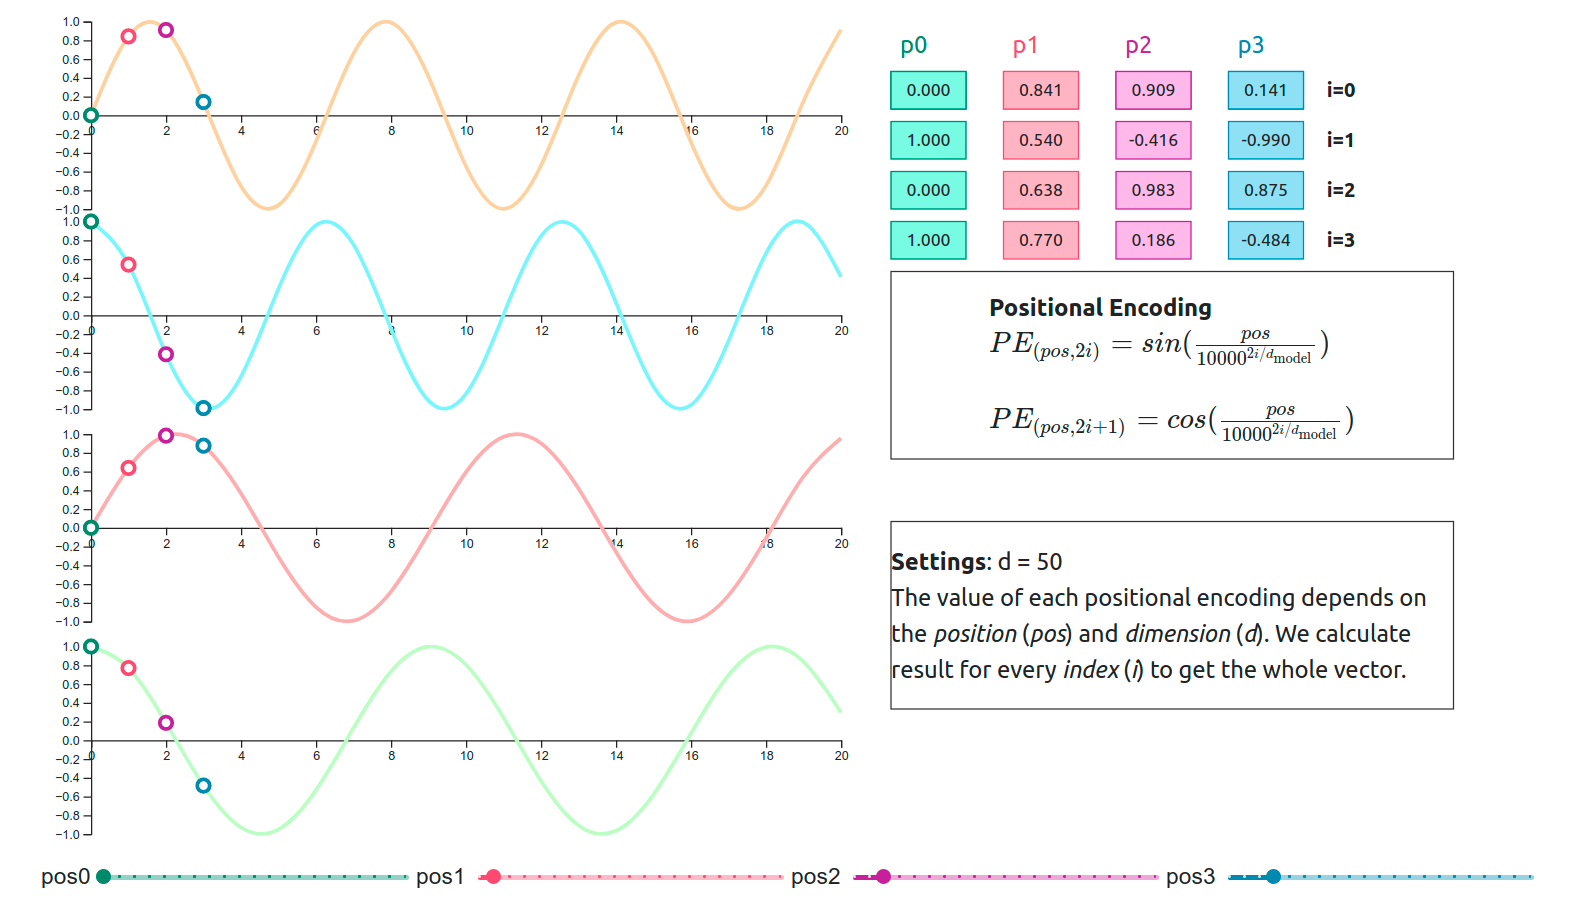

this is the positional embeddign class i have created

In [ ]:
import math

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self , d_model : int , seq_len : int , dropout : float ) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        # we are adding the dropout so that we can get the good accuracy
        self.dropout = nn.Dropout(dropout)

        # create a shape (seq_len , d_modal )
        # as our inention is to create ebddings for all the words
        # in the sequence and the embeddings is given based on
        # word position in sequence
        pe = torch.zeros(self.seq_len , self.d_model )
        # lets create a vector of sequence length
        # having the values from 0 to seq_len -1
        position = torch.arange( 0 , seq_len  , dtype = torch.float).unsqueeze(1)
        # .unsqueeze(1)
        # Purpose: Adds an extra dimension to the tensor at the specified position.
        # 1: Adds a new dimension at the second position (indexing starts from 0)
        #  now we have ( seq_len , 1 )
        # we want is sin(pos / (10000)^ (2i/d_modal)) and corresponding cos term
        div_term = torch.exp( torch.arange(0 , d_model , 2).float() * (-math.log(10000) / d_model ))
        # this is of size ( 1 , d_modal/2 )
        pe[: , 0::2] = torch.sin(position * div_term )
        pe[: , 1:: 2] = torch.cos(position * div_term )
        # here we are ging the sin term for even terms and cos terms for the odd temrs
        pe = pe.unsqueeze(0)
        # unsqueeze means it will add the dimension at the given location
        # here it we are saying at 0 th pos ( 1 , seq , d_modal) will be the result
        self.register_buffer('pe'  , pe )
        # note this is constant for every batch as every batch has same no of words
        # and same word embedding dim
        #  the .register buffer will will sva e the positional embeddings
        # and it can be used any time we want and this will not be involved in the
        # gradient  diesent as we know these are same for all
    def forward( self , x ):
        # here x is ( batch , seq_len , d_modal)
        x = x + ( self.pe[ : , : x.shape[1]  , : ]).requires_grad_(False)
        return self.dropout(x)

#--------------------------------------------------------------------------------------
# time_series = torch.randn( 3 , 20, 10)  # Batch size=16, seq_len=50, d_model=32
# encoder = PositionalEncoding(d_model = 10 , seq_len = 20 , dropout = 0.5)
# output = encoder.forward(time_series)
# print(output.shape)
# --------------------------------------------------------------------------------------

Question create
a 2 batch of seqlenth 4.
1) create the embeddings for these token ids whose embed dim is 4
2) now create the creat the positional embeddings using the class above written and add apply them to the batchs above

In [ ]:
input = torch.tensor([[1 , 2 , 4 , 5] , [ 0 , 5 , 3 ,2 ] ])
vocab_size = 10
embed_size = 4
embedding_layer = nn.Embedding(vocab_size , embed_size )
embed_input = embedding_layer(input)
print(f"embedded inputs =  {embed_input }")
positional_encoding_layer = PositionalEncoding( d_model = 4 , seq_len = 4 , dropout = 0.1 )
final_embed = positional_encoding_layer(embed_input )
print(final_embed)



embedded inputs =  tensor([[[-0.9609,  2.4804, -1.5524,  2.0594],
         [ 0.1844,  0.6102, -0.9112, -1.0695],
         [ 1.7090,  0.7006, -1.3105,  1.1337],
         [-0.5948, -1.2050,  0.2736,  1.0525]],

        [[-0.2091,  1.0619,  0.0143, -0.9438],
         [-0.5948, -1.2050,  0.2736,  1.0525],
         [-1.1037, -0.4260,  1.6664, -1.0828],
         [ 0.1844,  0.6102, -0.9112, -1.0695]]], grad_fn=<EmbeddingBackward0>)
tensor([[[-1.0677,  3.8671, -1.7249,  3.3993],
         [ 1.1399,  1.2784, -1.0013, -0.0773],
         [ 2.9093,  0.3160, -1.4339,  2.3706],
         [-0.0000, -0.0000,  0.3374,  2.2801]],

        [[-0.2323,  2.2910,  0.0000,  0.0000],
         [ 0.0000, -0.7385,  0.3151,  2.2805],
         [-0.2160, -0.9357,  1.8737, -0.0000],
         [ 0.3617, -0.4219, -0.9791, -0.0778]]], grad_fn=<MulBackward0>)
